In [1]:
import pandas as pd
import numpy as np
from copy import copy
import torch
import matplotlib.pyplot as plt

In [2]:
dataset_path = 'training_data_1718.csv'

In [3]:
def file_to_data(filename):
    
    # read file
    raw = pd.read_csv(filename)
    
    # define columns to be extracted
    ndvi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., ndvi_mean24
    savi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., savi_mean24
    evi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., evi_mean24

    # extract each feature
    ndvi_timeseries = raw[ndvi_col]
    savi_timeseries = raw[savi_col]
    evi_timeseries = raw[evi_col]
    
    # dimension stack
    data = np.dstack([ndvi_timeseries, savi_timeseries, evi_timeseries])
    
    # get only label
    label = raw.iloc[:, -1]
    
    return data, label

def data_to_lv1_x_y(data, labels):
    
    # export all X
    # but reclass the plant cane -> 100, ratoon cane -> 200
    target = copy(labels)
    target[target > 200] = 200
    target[(target < 200) & (target > 100)] = 100
    
    return data, target

def data_to_lv2_x_y(data, target):
    
    # export X plant which labels are 100-200
    X_plant = data[(target > 100) & (target <200)]
    
    # export X ratoon which labels are >200
    X_ratoon = data[target > 200]
    
    # export y plant which labels are 100-200
    y_plant = target[(target > 100) & (target < 200)]
    
    # export y ratoon which labels are >200
    y_ratoon = target[target > 200]
    
    return X_plant, y_plant, X_ratoon, y_ratoon

def label_encode(y):
    
    target = copy(y)
    # redefine the cane plantation label to be 1 - 24
    new_y = [int(str(label)[1:]) for label in target]
    
    return np.array(new_y)

In [4]:
data_train, labels_train = file_to_data('training_data_1718.csv')
data_test, labels_test = file_to_data('training_data_1819.csv')

In [5]:
X_plant_train, y_plant_train, X_ratoon_train, y_ratoon_train = data_to_lv2_x_y(data_train, labels_train)
X_plant_test, y_plant_test, X_ratoon_test, y_ratoon_test = data_to_lv2_x_y(data_test, labels_test)

In [6]:
y_plant_train.unique()

array([101, 102, 103, 104, 105, 106, 107, 108, 121, 122, 123, 124])

In [7]:
def makelabel(y):
    y = y.to_numpy()
    for i in range(len(y)):
        if y[i] %100 >0 and y[i] %100<=2:
              y[i] = 0 
        elif y[i] %100>2 and y[i] %100<=4:
              y[i] = 1 
        elif y[i] %100>4 and y[i] %100<=6:
              y[i] = 2 
        elif y[i] %100>6 and y[i] %100<=8:
              y[i] = 3                 
        elif y[i] %100>8 and y[i] %100<=10:
              y[i] = 4 
        elif y[i] %100>20 and y[i] %100<=22:
              y[i] = 10 
        elif y[i] %100>22 and y[i] %100<=24:
              y[i] = 11           
    return y
y_plant_train = makelabel(y_plant_train)
y_ratoon_train = makelabel(y_ratoon_train)

y_plant_test = makelabel(y_plant_test)
y_ratoon_test = makelabel(y_ratoon_test)

y_plant_train = label_encode(y_plant_train)-1
y_ratoon_train = label_encode(y_ratoon_train)-1

y_plant_test = label_encode(y_plant_test)-1
y_ratoon_test = label_encode(y_ratoon_test)-1

In [8]:
print(f'numeric class of y train: {np.unique(y_plant_train)}')
print(f'numeric class of y test: {np.unique(y_plant_test)}')

numeric class of y train: [ 0  1  2  3 10 11]
numeric class of y test: [ 0  1  2  3 10 11]


In [9]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [10]:
X_plant_train = X_plant_train.reshape(X_plant_train.shape[0], -1)
X_ratoon_train = X_ratoon_train.reshape(X_ratoon_train.shape[0], -1)
print(f'X plant train: {X_plant_train.shape}')
print(f'X ratoon train: {X_ratoon_train.shape}')

X plant train: (4489, 72)
X ratoon train: (7878, 72)


In [11]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_plant_train, y_plant_train = ros.fit_resample(X_plant_train, y_plant_train)
X_ratoon_train, y_ratoon_train = ros.fit_resample(X_ratoon_train, y_ratoon_train)

print(f'after oversampled-> X plant shape: {X_plant_train.shape}')
print(f'after oversampled-> X ratoon shape: {X_ratoon_train.shape}')

after oversampled-> X plant shape: (10206, 72)
after oversampled-> X ratoon shape: (17650, 72)


In [12]:
X_plant_train = X_plant_train.reshape(X_plant_train.shape[0], 24,3)
X_ratoon_train = X_ratoon_train.reshape(X_ratoon_train.shape[0], 24,3)

print(f'X plant train: {X_plant_train.shape}')
print(f'X ratoon train: {X_ratoon_train.shape}')

X plant train: (10206, 24, 3)
X ratoon train: (17650, 24, 3)


In [13]:
"""X_plant_train = X_plant_train.transpose(0,2,1)[:, np.newaxis,:,:]
X_ratoon_train = X_ratoon_train.transpose(0,2,1)[:, np.newaxis,:,:]"""

X_plant_train = X_plant_train.transpose(0,2,1)[:,:,:14]
X_ratoon_train = X_ratoon_train.transpose(0,2,1)[:,:,:14]


In [14]:
from tensorflow.keras.utils import to_categorical
y_plant_train = to_categorical(y_plant_train)
y_ratoon_train = to_categorical(y_ratoon_train)
print(y_plant_train.shape)
print(y_ratoon_train.shape)

(10206, 12)
(17650, 12)


In [15]:
print(f'X plant train: {X_plant_train.shape}')
print(f'X ratoon train: {X_ratoon_train.shape}')

X plant train: (10206, 3, 14)
X ratoon train: (17650, 3, 14)


In [16]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

def Xy_dataloader(X_numpy, y_numpy, batch_size=1000):
    
    X_tensor = torch.tensor(X_numpy).float()
    y_tensor = torch.tensor(y_numpy)
    
    dataset = TensorDataset(X_tensor, y_tensor)

    loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
    
    return loader

In [17]:
from sklearn.model_selection import train_test_split

X_plant_train, X_plant_valid, y_plant_train, y_plant_valid = train_test_split(X_plant_train, y_plant_train  , test_size=0.3, stratify=y_plant_train)


In [18]:
X_ratoon_train, X_ratoon_valid, y_ratoon_train, y_ratoon_valid = train_test_split(X_ratoon_train, y_ratoon_train, test_size=0.3, stratify=y_ratoon_train)

In [19]:
xtrain_mix = np.concatenate((X_plant_train, X_ratoon_train), axis=0)
ytrain_mix = np.concatenate((y_plant_train, y_ratoon_train), axis=0)

xvali_mix = np.concatenate((X_plant_valid, X_ratoon_valid), axis=0)
yvali_mix = np.concatenate((y_plant_valid, y_ratoon_valid), axis=0)

train_loader = Xy_dataloader(xtrain_mix, ytrain_mix, 256)
valid_loader = Xy_dataloader(xvali_mix, yvali_mix, 256)


# Conv1D -> LSTM

In [20]:
hidden_dim = 128
output_dim = 12 #len(np.unique(y_plant_train))
num_layers = 2
bidirectional = True
dropout = 0.5

num_epochs = 100
lr = 0.0001
cuda = 2

In [21]:
import torch.nn as nn
from torch.nn import functional as F
class con1dlstm(nn.Module):
    def __init__(self):
        super().__init__()
               
        self.layer1 = nn.Sequential(
            nn.Conv1d(3,64, 4, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.5))      
        self.lstm = nn.LSTM(6, hidden_dim, num_layers=num_layers,
                    bidirectional=bidirectional, 
                    dropout=dropout,
                    batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)   
        self.fc1 = nn.Linear(15356, output_dim)
    
    
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.unsqueeze(2)  # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, seq_len, 1]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), seq_len] * [batch_size, seq_len, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.cpu().data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]
    
    def forward(self, x):
        out0 = self.layer1(x)
        out,(hn, cn) = self.lstm(out0)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        
        attn_output, attention = self.attention_net(out, hn)
        
        return self.fc(attn_output)

In [22]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param) #<---here

In [23]:
model = con1dlstm().cuda(cuda)
model.apply(initialize_weights)

con1dlstm(
  (layer1): Sequential(
    (0): Conv1d(3, 64, kernel_size=(4,), stride=(2,))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=12, bias=True)
  (fc1): Linear(in_features=15356, out_features=12, bias=True)
)

In [24]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr) #<----changed to Adam
#optimizer = optim.RMSprop(model.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss() #combine sigmoid with binary cross entropy
#criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()

In [25]:
def cnn_acc(preds,y):
    rounded_preds = torch.round(torch.softmax(preds.data,dim=1))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc/12

In [26]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (features, label) in enumerate(loader): 
        features   = features.cuda(cuda)
        label = label.cuda(cuda)        
        #predict
        predictions = model(features)
        #calculate loss
        loss = criterion(predictions, label)
        acc = cnn_acc(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [27]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (features, label) in enumerate(loader): 
            features   = features.cuda(cuda)
            label = label.cuda(cuda)

            predictions = model(features)
            
            loss = criterion(predictions, label)
            acc = cnn_acc(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [28]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in range(num_epochs):

    train_loss,train_acc = train(model, train_loader, optimizer , criterion)
    valid_loss,valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'tensor.pt')
    
    if epoch%10 == 0:
        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 0.513 | Train Acc: 91.67%
	 Val. Loss: 0.238 |  Val. Acc: 91.67%
Epoch: 11 | Train Loss: 0.179 | Train Acc: 91.77%
	 Val. Loss: 0.166 |  Val. Acc: 92.25%
Epoch: 21 | Train Loss: 0.157 | Train Acc: 92.38%
	 Val. Loss: 0.146 |  Val. Acc: 93.04%
Epoch: 31 | Train Loss: 0.148 | Train Acc: 92.74%
	 Val. Loss: 0.139 |  Val. Acc: 93.22%
Epoch: 41 | Train Loss: 0.140 | Train Acc: 93.03%
	 Val. Loss: 0.139 |  Val. Acc: 93.10%
Epoch: 51 | Train Loss: 0.135 | Train Acc: 93.28%
	 Val. Loss: 0.130 |  Val. Acc: 93.70%
Epoch: 61 | Train Loss: 0.132 | Train Acc: 93.43%
	 Val. Loss: 0.125 |  Val. Acc: 93.81%
Epoch: 71 | Train Loss: 0.131 | Train Acc: 93.49%
	 Val. Loss: 0.125 |  Val. Acc: 93.90%
Epoch: 81 | Train Loss: 0.129 | Train Acc: 93.54%
	 Val. Loss: 0.123 |  Val. Acc: 93.90%
Epoch: 91 | Train Loss: 0.127 | Train Acc: 93.70%
	 Val. Loss: 0.124 |  Val. Acc: 93.95%


Text(0, 0.5, 'Loss during Trianing')

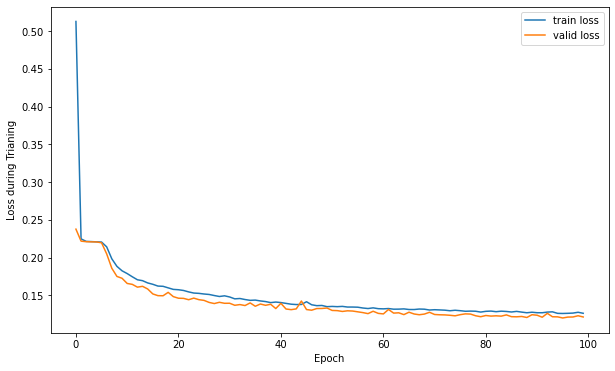

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss during Trianing')

Text(0, 0.5, 'Accuracy during Trianing')

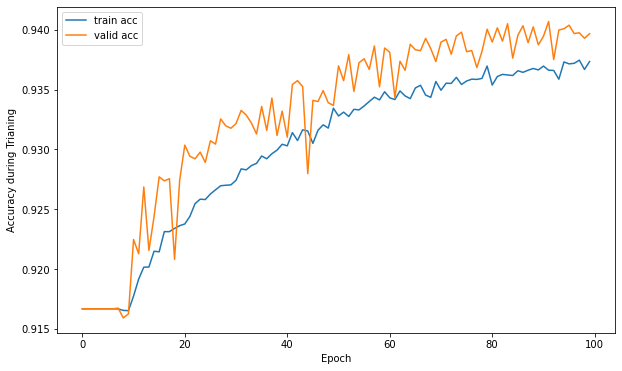

In [30]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy during Trianing')

In [31]:
def predict_model(model, X_test):
    
    model.eval()
    
    x = torch.tensor(X_test).float()
            
    out = model(x.cuda(cuda))
    rounded_preds = torch.round(torch.softmax(out.data,dim=1))
    #print(out)
    #print(rounded_preds)
    #pred = torch.max(out, 1)[1]
    
    return rounded_preds.cpu().numpy()

In [32]:
X_plant_test = X_plant_test.transpose(0,2,1)[:,:,:14]
X_ratoon_test = X_ratoon_test.transpose(0,2,1)[:,:,:14]
y_plant_test = to_categorical(y_plant_test)
y_ratoon_test = to_categorical(y_ratoon_test)

In [33]:
xtest_mix = np.concatenate((X_plant_test, X_ratoon_test), axis=0)
ytest_mix = np.concatenate((y_plant_test, y_ratoon_test), axis=0)

print(xtest_mix.shape)
print(ytest_mix.shape)

(7452, 3, 14)
(7452, 12)


In [34]:
y_pred = predict_model(model,xtest_mix)

In [35]:
y_pred = np.argmax(y_pred, axis = 1)
ytest_mix = np.argmax(ytest_mix, axis = 1)

In [36]:
from sklearn.metrics import classification_report

print(classification_report(ytest_mix, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.79      0.25       898
           1       0.53      0.24      0.33      2163
           2       0.71      0.11      0.18      2410
           3       0.68      0.40      0.50      1729
          10       0.15      1.00      0.26         3
          11       0.29      0.49      0.36       249

    accuracy                           0.31      7452
   macro avg       0.42      0.50      0.32      7452
weighted avg       0.57      0.31      0.31      7452



In [37]:
from sklearn.metrics import confusion_matrix

cf_matrix_plant = confusion_matrix(ytest_mix, y_pred)

<AxesSubplot:>

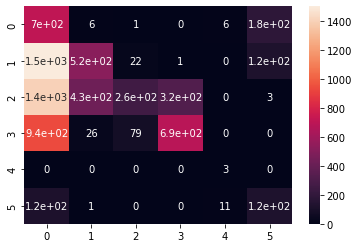

In [38]:
import seaborn as sns
sns.heatmap(cf_matrix_plant, annot=True)